In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [3]:
titles = open('../data/tangpoetry_titles.txt').read().split('\n')
titles[:10]

['廣州王園寺伏日即事寄北中親友', '春日', '失題', '古意', '勗曹生', '琴歌', '廢長行', '玉女詞', '苦別', '石城']

In [4]:
len(titles)

40095

In [10]:
char_lists = []
for title in titles:
    char_lists.extend(list(title))
    
char_sets = set(char_lists)
len(char_sets)

4244

In [11]:
stoi = {s:i+2 for i, s in enumerate(char_sets)}
stoi[" 《"] = 0
stoi["》 "] = 1
itos = {i:s for s, i in stoi.items()}
len(itos)

4246

In [17]:
block_size = 3
X, Y = [], []

for t in titles[:3]:
    context = [0] * block_size
    for ch in list(t) + ["》 "]:
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        # print("".join([itos[i] for i in context]) + "---->" + ch)
        
        context = context[1:] + [ix]

X = torch.Tensor(X)
Y = torch.Tensor(Y)
print(X.shape, Y.shape)

torch.Size([21, 3]) torch.Size([21])


In [20]:
block_size = 3

def build_dataset(titles):
    X, Y = [], []
    
    for t in titles:
        context = [0] * block_size
        
        for ch in list(t) + ["》 "]:
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print("".join([itos[i] for i in context]) + "---->" + ch)
            
            context = context[1:] + [ix]

    X = torch.Tensor(X)
    Y = torch.Tensor(Y)
    
    return X, Y

import random
random.seed(42)
random.shuffle(titles)
n1 = int(0.8*len(titles))
n2 = int(0.9*len(titles))

Xtr, Ytr = build_dataset(titles[:n1])
Xdev, Ydev = build_dataset(titles[n1:n2])
Xte, Yte = build_dataset(titles[n2:])

print(Xtr.shape, Ytr.shape)
print(Xdev.shape, Ydev.shape)
print(Xte.shape, Yte.shape)

torch.Size([240830, 3]) torch.Size([240830])
torch.Size([30045, 3]) torch.Size([30045])
torch.Size([30484, 3]) torch.Size([30484])


In [29]:
n_embedding_table = len(itos)
embedding_size = 10

In [30]:
g = torch.Generator().manual_seed(42)
C = torch.randn(n_embedding_table, embedding_size, generator=g)
W1 = torch.randn(block_size*embedding_size, 128, generator=g)
b1 = torch.randn(128, generator=g)
W2 = torch.randn(128, n_embedding_table, generator=g)
b2 = torch.randn(n_embedding_table, generator=g)
parameters = [C, W1, b1, W2, b2]

In [33]:
sum(p.numel() for p in parameters)

594162

In [34]:
for p in parameters:
  p.requires_grad = True

In [35]:
lri = []
lossi = []
stepi = []

In [44]:
for i in range(2000):
    
    ix = torch.randint(0, len(Xtr), (128,))
    x = Xtr[ix].long()
    
    embed = C[x]
    embed = embed.view(embed.shape[0], -1)
    h = torch.tanh(embed @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Ytr[ix].long())
    
    for p in parameters:
        p.grad = None
    loss.backward()
    
    lr = 0.1 if i < 10000 else 0.01
    for p in parameters:
        p.data -= lr * p.grad
        
    stepi.append(i)
    lossi.append(loss.log10().mean().item())

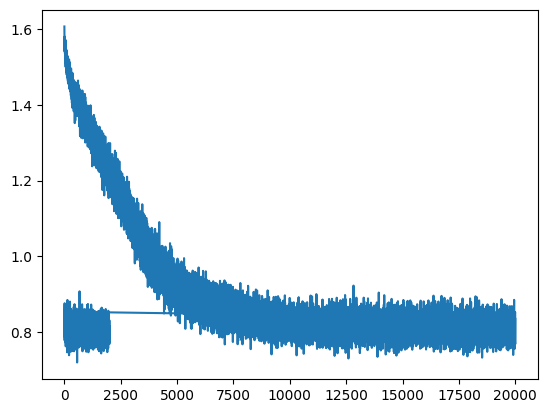

In [45]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(stepi, lossi)

In [46]:
embed = C[Xtr.long()]
embed = embed.view(embed.shape[0], -1)
h = torch.tanh(embed @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ytr.long())
loss

tensor(6.3640, grad_fn=<NllLossBackward0>)

In [47]:
embed = C[Xdev.long()]
embed = embed.view(embed.shape[0], -1)
h = torch.tanh(embed @ W1 + b1)
logits = h @ W2 + b2
loss = F.cross_entropy(logits, Ydev.long())
loss

tensor(6.4602, grad_fn=<NllLossBackward0>)

In [48]:
context = [0] * block_size
C[torch.tensor([context])].shape

torch.Size([1, 3, 10])

In [59]:
g = torch.Generator().manual_seed(42)

for _ in range(20):
    
    out = []
    ix = 0
    
    while True:
        embed = C[torch.tensor([context])].view(1, -1)
        h = torch.tanh(embed @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=-1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        
        if ix == 1:
            break
        
    print("《" + "".join([itos[i] for i in out]))

《》 
《別僧》 
《來延送聞冊歌》 
《侍王夔奉》 
《時曹》 
《（陈州監元》 
《望語張》 
《邊目》 
《日花章人》 
《意閬山》 
《言中齋》 
《見杏春元》 
《僧樂》 
《裴事閣溪處中》 
《兼（湯陟蘋東陰友吟題六》 
《十》 
《曲精贊行》 
《先人》 
《》 
《》 
